**Women's Clothing E-Commerce Reviews**

**EDA(non text)**

1.1 Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora import Dictionary
from gensim.models import LdaModel


In [2]:
df = pd.read_csv('data/WomensClothingE-CommerceReviews.csv')

1.2 Basic info

In [3]:
df.head()

Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe()

Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.500000    918.118709     43.198544      4.196032   
std     6779.968547    203.298980     12.279544      1.110031   
min        0.000000      0.000000     18.000000      1.000000   
25%     5871.250000    861.000000     34.000000      4.000000   
50%    11742.500000    936.000000     41.000000      5.000000   
75%    17613.750000   1078.000000     52.000000      5.000000   
max    23485.000000   1205.000000     99.000000      5.000000   

       Recommended IND  Positive Feedback Count  
count     23486.000000             23486.000000  
mean          0.822362                 2.535936  
std           0.382216                 5.702202  
min           0.000000                 0.000000  
25%           1.000000                 0.000000  
50%           1.000000                 1.000000  
75%           1.000000                 3.000000  
max           1.000000               122.000000

1.3 Missing Value and dupliacte

C:\Users\Alvis\AppData\Local\Temp\ipykernel_14012\332695394.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


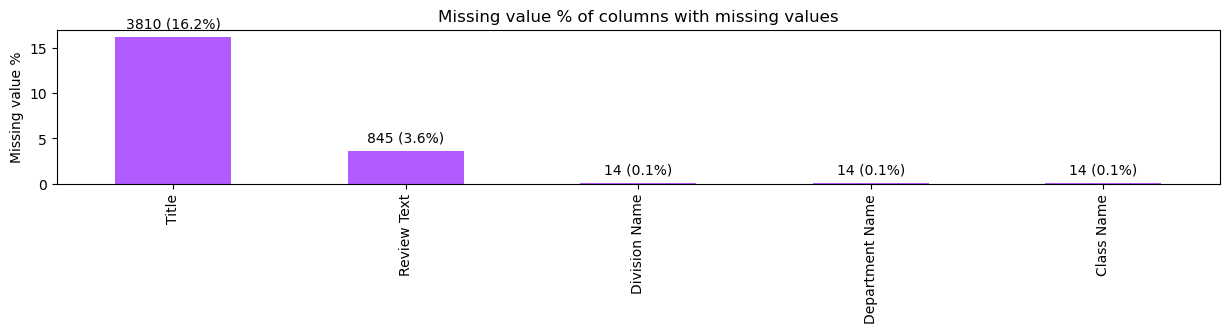

In [6]:
# missing value % and counts
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='#B15BFF')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value %")
plt.title("Missing value % of columns with missing values")
plt.show()

In [7]:
# Delete rows with missing values in "Review Text"
print("Rows before deleting missing values in review text: ", df.shape[0])
df.dropna(subset=['Review Text'], inplace=True)
print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


In [8]:
# Fill in missing values with blank for other object type columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')
                    
df.isna().sum().sum()

0

In [9]:
# Drop "Unamed: 0" column
df.drop("Unnamed: 0", axis=1, inplace=True)

In [10]:
# check duplicates
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


In [11]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


1.4 Distribution

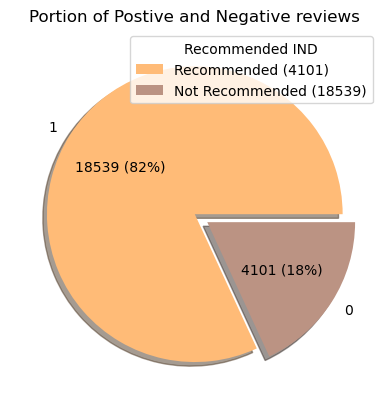

In [12]:
# Plot dependent variable distribution
# parameters for plot
sizes = df['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#FFBB77', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()

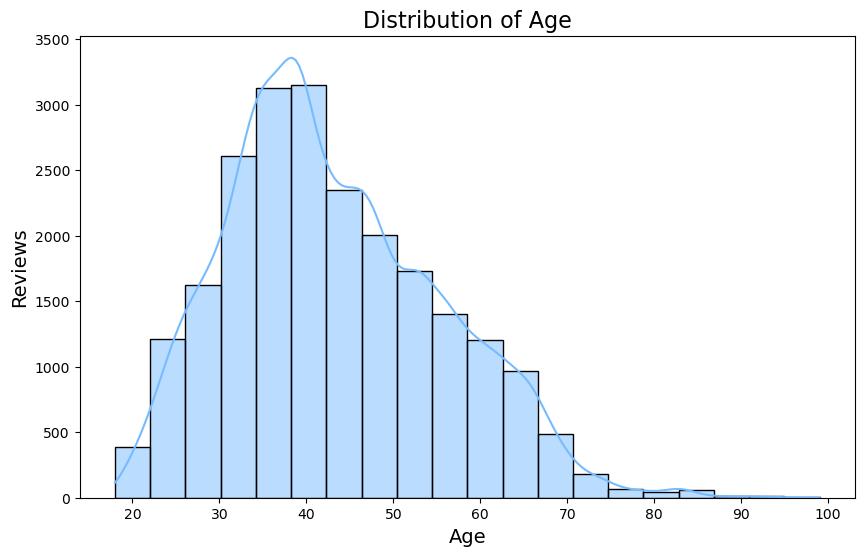

In [13]:
# Plot Age Distribution

# Histogram for Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='#77BBFF')

# Adding title and labels
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Reviews', fontsize=14)

# Show the plot
plt.show()


C:\Users\Alvis\AppData\Local\Temp\ipykernel_14012\646103060.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='Blues')


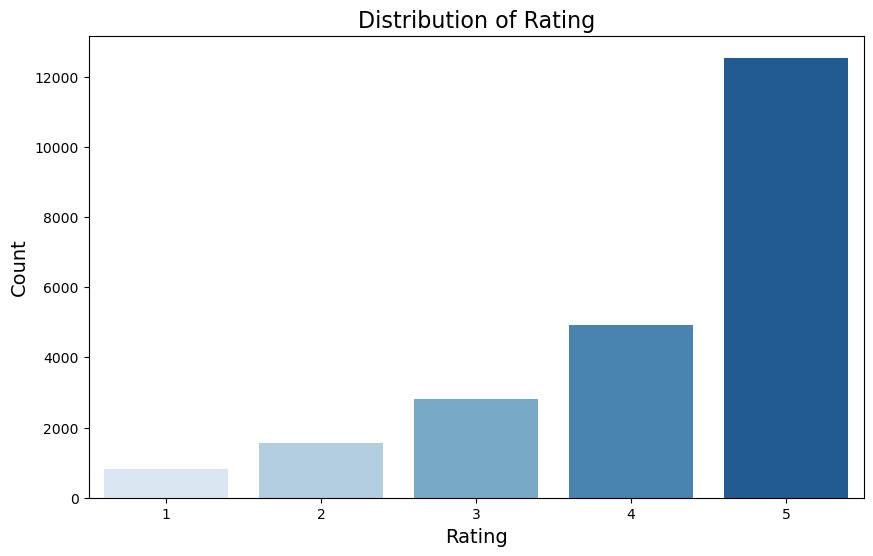

In [14]:
# Plot Rating Distribution

plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='Blues')
plt.title('Distribution of Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()



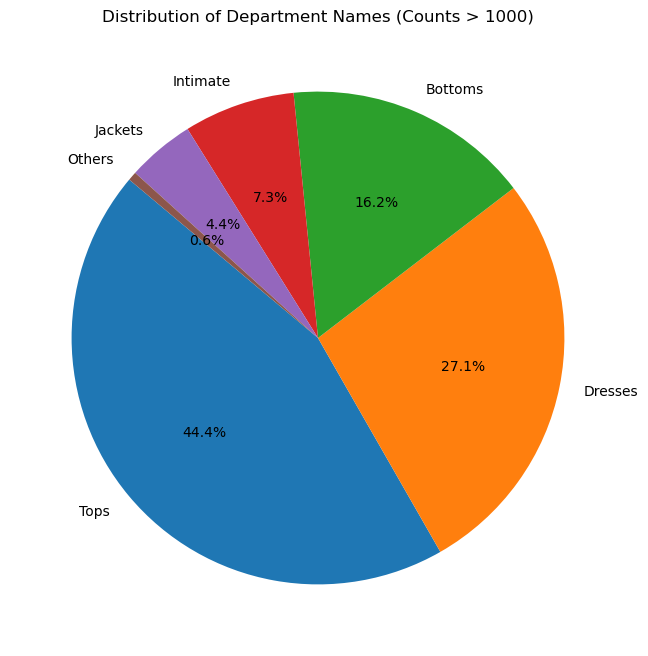

In [15]:
threshold = 1000
class_counts = df['Department Name'].value_counts()
filtered_counts = class_counts[class_counts > threshold]
others_count = class_counts[class_counts <= threshold].sum()

new_counts = filtered_counts.copy()
new_counts['Others'] = others_count

plt.figure(figsize=(8, 8))
plt.pie(new_counts, labels=new_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Department Names (Counts > 1000)')
plt.show()

In [16]:
# Check total Cloth items in dataset
print("Clothing Item Counts in dataset: ", len(df["Clothing ID"].unique()))

Clothing Item Counts in dataset:  1179


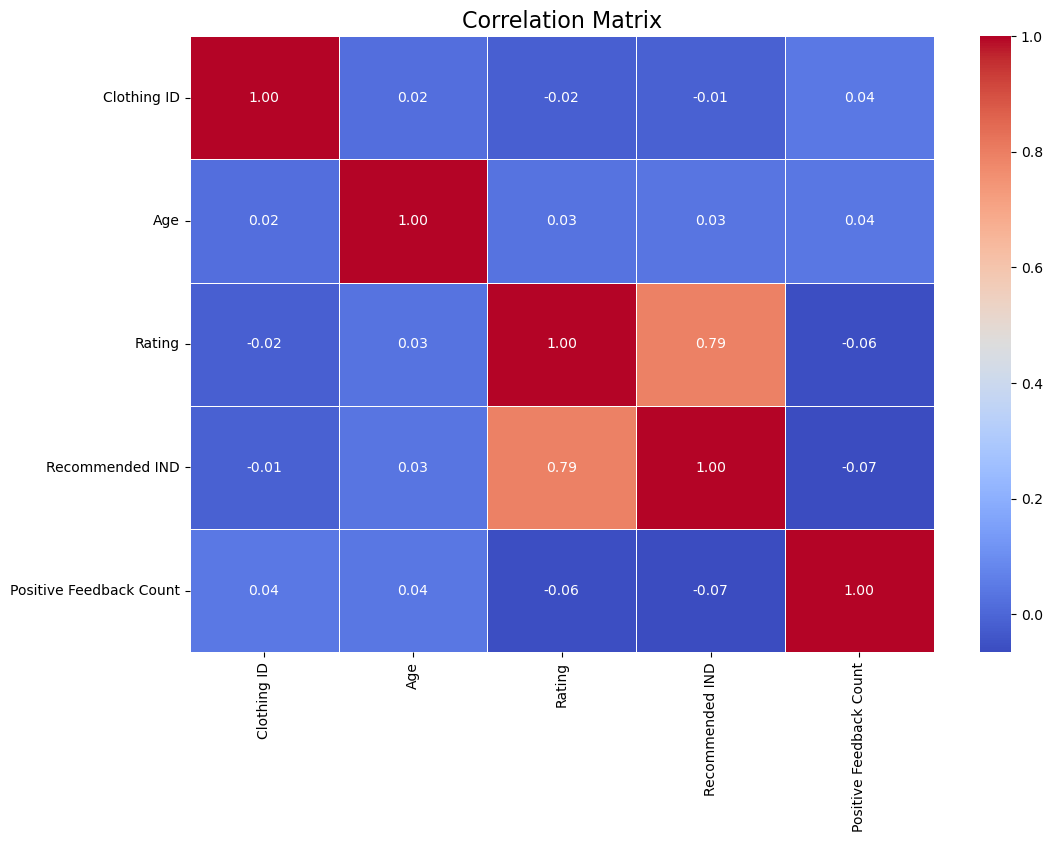

In [17]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Step 3: Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Step 4: Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    fmt=".2f",   # Format to 2 decimal places
    cmap='coolwarm', 
    linewidths=0.5
)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

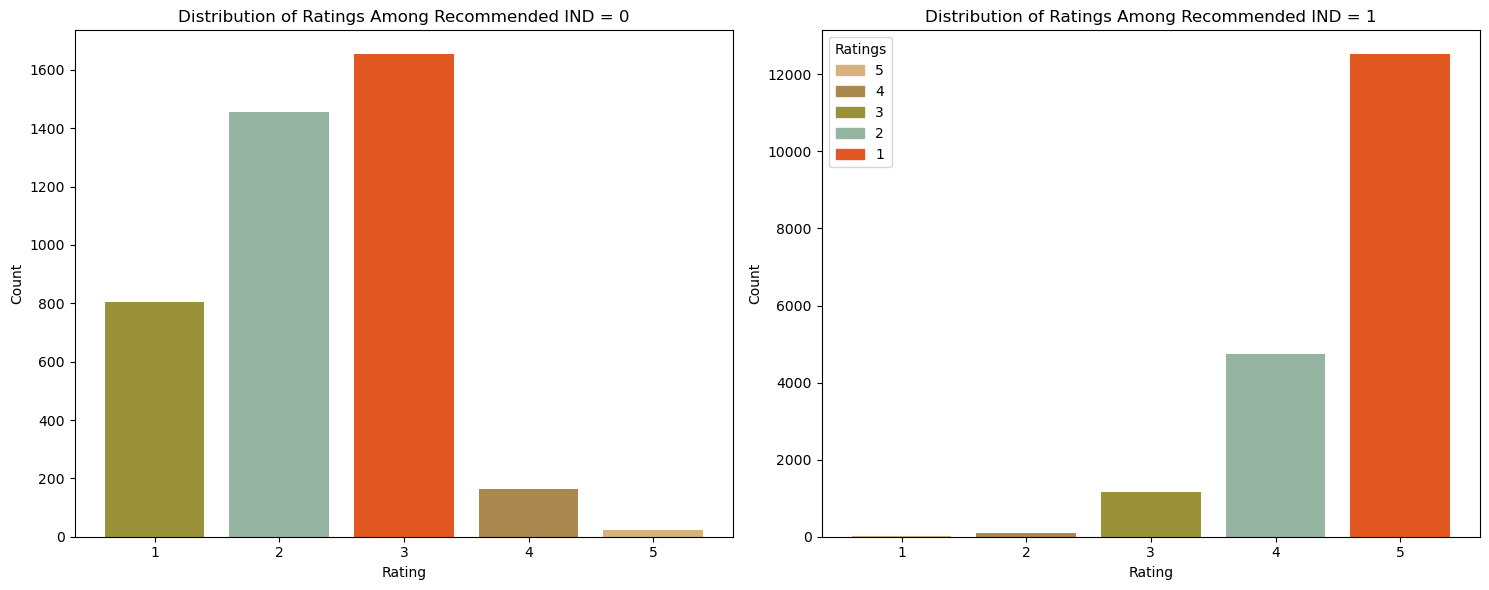

In [18]:
df_recommended_0 = df[df['Recommended IND'] == 0]
df_recommended_1 = df[df['Recommended IND'] == 1]
colors_0=['#9a9238', '#96b4a2', '#e25822', '#aa884f', '#d6b27f']
colors_1=['#d6b27f', '#aa884f', '#9a9238', '#96b4a2', '#e25822'] #order of 54321

# Create two subplots for the bar charts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart for Recommended IND = 0
sizes_0 = df_recommended_0['Rating'].value_counts().sort_index()
ax[0].bar(sizes_0.index, sizes_0.values, color=colors_0)
ax[0].set_title('Distribution of Ratings Among Recommended IND = 0')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')
ax[0].set_xticks(sizes_0.index)

# Bar chart for Recommended IND = 1
sizes_1 = df_recommended_1['Rating'].value_counts().sort_index()
ax[1].bar(sizes_1.index, sizes_1.values, color=colors_1)
ax[1].set_title('Distribution of Ratings Among Recommended IND = 1')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Count')
ax[1].set_xticks(sizes_1.index)

# Add a legend
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors_1]
labels = sorted(df['Rating'].unique(), reverse=True)
plt.legend(handles, labels, title="Ratings")

plt.tight_layout()
plt.show()

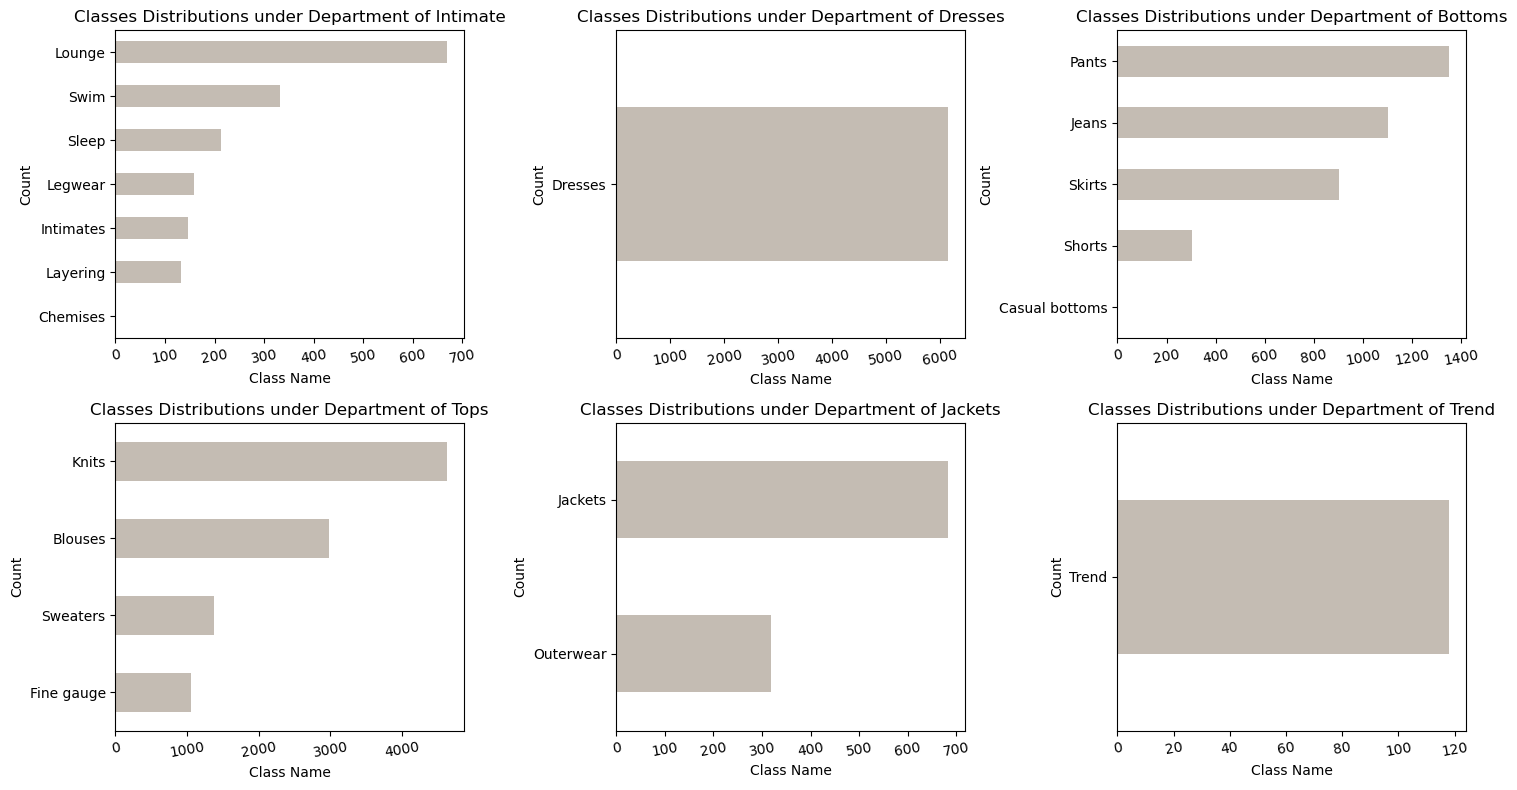

In [19]:
# Get unique department names
departments = df['Department Name'].unique()
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j < len(departments):
            department = departments[i * num_cols + j]
            department_data = df[df['Department Name'] == department]
            counts = department_data['Class Name'].value_counts().sort_values(ascending=True)
            counts.plot(kind='barh', ax=axes[i, j], color='#c4bcb3')

            axes[i, j].set_title(f'Classes Distributions under Department of {department}', fontsize=12)
            axes[i, j].set_xlabel('Class Name', fontsize=10)
            axes[i, j].set_ylabel('Count', fontsize=10)
            axes[i, j].tick_params(axis='x', rotation=10)
        else:
            # Hide empty subplots
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

**EDA(Text)**

In [20]:
# Append 'Title' to 'Review Text'
df['Review Text'] = df.apply(lambda row: row['Review Text']  + ' ' + row['Title'], axis=1)

# Drop the "Title" column if it's no longer needed
df.drop(columns=['Title'], inplace=True)

In [25]:

# Filter data based on Recommended IND
recommended_reviews = df[df['Rating'] == 5][df['Recommended IND'] == 1]['Review Text'].dropna()
not_recommended_reviews = df[df['Rating'] == 1][df['Recommended IND'] == 0]['Review Text'].dropna()

# Combine cleaned text for each category
text_recommended = " ".join(recommended_reviews)
text_not_recommended = " ".join(not_recommended_reviews)


C:\Users\Alvis\AppData\Local\Temp\ipykernel_14012\2044512604.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommended_reviews = df[df['Rating'] == 5][df['Recommended IND'] == 1]['Review Text'].dropna()
C:\Users\Alvis\AppData\Local\Temp\ipykernel_14012\2044512604.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_recommended_reviews = df[df['Rating'] == 1][df['Recommended IND'] == 0]['Review Text'].dropna()


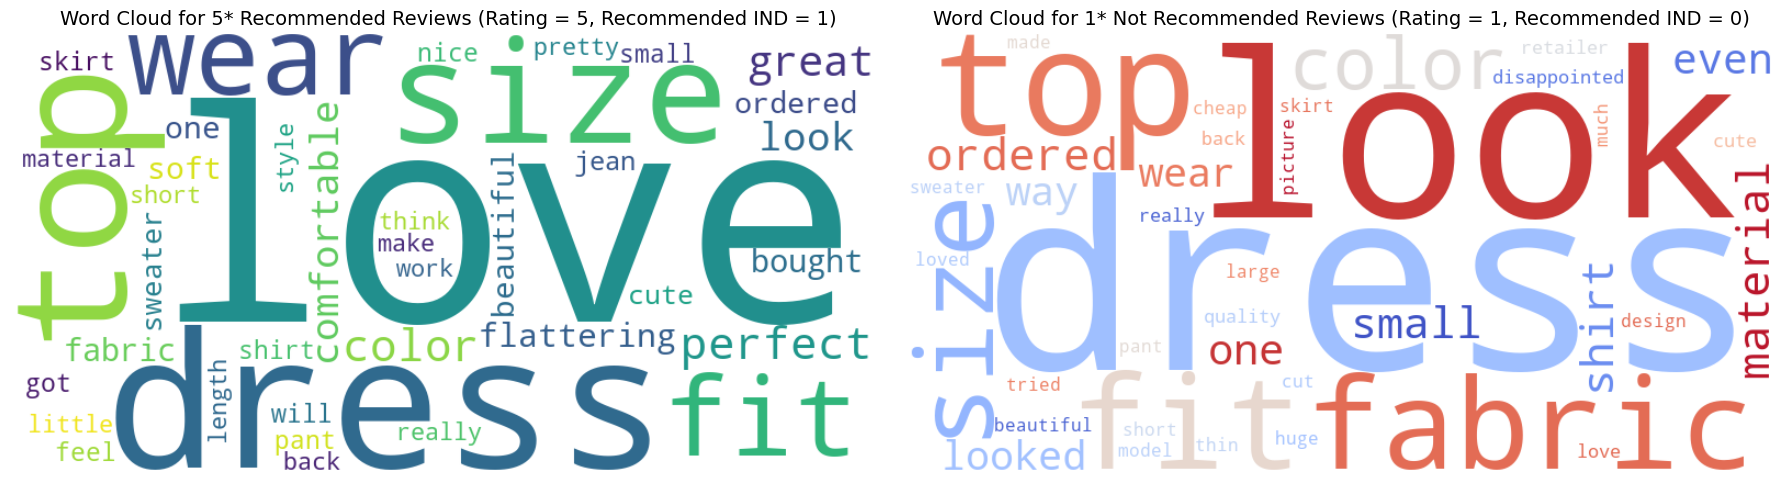

In [27]:
# Generate Word Clouds
wordcloud_recommended = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=40, 
    colormap='viridis'
).generate(text_recommended)

wordcloud_not_recommended = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=40, 
    colormap='coolwarm'
).generate(text_not_recommended)

# Display the Word Clouds
plt.figure(figsize=(18, 6))

# Word Cloud for Recommended IND = 1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_recommended, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 5* Recommended Reviews (Rating = 5, Recommended IND = 1)", fontsize=14)

# Word Cloud for Recommended IND = 0
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_not_recommended, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 1* Not Recommended Reviews (Rating = 1, Recommended IND = 0)", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def preprocess_text(text):
    
    text = text.lower()
    text = re.sub('\W+', ' ', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words and too short
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

def get_dictionary(texts):
    dictionary = Dictionary(texts)
    return dictionary

def create_bag_of_words(texts, dictionary):
    corpus_bow = [dictionary.doc2bow(text) for text in texts]
    return corpus_bow

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alvis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
df['preprocessed_text'] = df['Review Text'].apply(preprocess_text)

In [28]:
dictionary = get_dictionary(df['preprocessed_text'].tolist())
corpus_bow = create_bag_of_words(df['preprocessed_text'].tolist(), dictionary)


In [63]:
# 5. Train LDA model
def train_lda_model(corpus_bow, dictionary, num_topics=3, num_passes=20):
    lda_model = LdaModel(corpus_bow,
                         num_topics=num_topics,
                         id2word=dictionary,
                         iterations=400,
                         passes=num_passes)
    return lda_model

# Train the LDA model
num_topics = 4  # You can adjust the number of topics
lda_model = train_lda_model(corpus_bow, dictionary, num_topics=num_topics)

# 6. Print Topics
def print_topics(lda_model, num_words=10):
    for topic_id in range(lda_model.num_topics):
        topic_words = lda_model.show_topic(topic_id, topn=num_words)
        print(f"Topic {topic_id + 1}:")
        print(", ".join([word for word, prob in topic_words]))
        print()

print_topics(lda_model)
print(df['preprocessed_text'].head(10))
print('Dictionary:', dictionary)
print('Bag of Words:', corpus_bow)


Topic 1:
size, fit, top, small, like, look, order, would, larg, run

Topic 2:
color, sweater, love, look, soft, like, nice, beauti, sleev, skirt

Topic 3:
love, great, top, wear, fit, jean, comfort, perfect, pant, cute

Topic 4:
dress, love, beauti, wear, fit, fabric, look, flatter, perfect, skirt

0              [absolut, wonder, silki, sexi, comfort]
1    [love, dress, sooo, pretti, happen, find, stor...
2    [high, hope, dress, realli, want, work, initi,...
3    [love, love, love, jumpsuit, fun, flirti, fabu...
4    [shirt, flatter, due, adjust, front, tie, perf...
5    [love, traci, rees, dress, one, petit, feet, t...
6    [ade, basket, hte, last, mintu, see, would, lo...
7    [order, carbon, store, pick, ton, stuff, alway...
8    [love, dress, usual, get, run, littl, snug, bu...
9    [125, lb, order, petit, make, sure, length, lo...
Name: preprocessed_text, dtype: object
Dictionary: Dictionary<9963 unique tokens: ['absolut', 'comfort', 'sexi', 'silki', 'wonder']...>
Bag of Words: 

In [66]:
def get_document_topics(lda_model, corpus_bow):
    document_topics = []
    for doc_bow in corpus_bow:
        doc_topics = lda_model[doc_bow]
        document_topics.append(doc_topics)
    return document_topics

document_topics = get_document_topics(lda_model, corpus_bow)

In [68]:
def get_dominant_topic(doc_topics):
    dominant_topic = None
    max_prob = -1
    for topic_id, prob in doc_topics:
        if prob > max_prob:
            max_prob = prob
            dominant_topic = topic_id
    return dominant_topic

dominant_topics = [get_dominant_topic(doc_topics) for doc_topics in document_topics]

In [81]:
topic_names = {
    0: "Fit and size",
    1: "Appearance",
    2: "Comfort",
    3: "Material and made"
}

In [82]:
df['dominant_topic'] = dominant_topics  
df['topic_name'] = df['dominant_topic'].map(topic_names) 

print(df[['Review Text', 'topic_name']].head())

                                         Review Text         topic_name
0  Absolutely wonderful - silky and sexy and comf...  Material and made
1  Love this dress!  it's sooo pretty.  i happene...       Fit and size
2  I had such high hopes for this dress and reall...       Fit and size
3  I love, love, love this jumpsuit. it's fun, fl...            Comfort
4  This shirt is very flattering to all due to th...            Comfort


In [ ]:
from gensim.models import CoherenceModel
num_topics = [3,4,5,6,7,8,9,10]  # You can adjust the number of topics

for i in num_topics:
    # Train the LDA model
    lda_model = train_lda_model(corpus_bow, dictionary, num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed_text'].tolist(), dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda, i)

Coherence Score:  0.36579295445988574 10
Coherence Score:  0.3689239934381731 20
Coherence Score:  0.3655967745890343 30
Coherence Score:  0.35038045911839927 40
Coherence Score:  0.3747437331900397 50


In [64]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed_text'].tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda, 4)

Coherence Score:  0.37882234048422414 4


In [40]:
lda_model = train_lda_model(corpus_bow, dictionary, num_topics=9)
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed_text'].tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda, 9)

Coherence Score:  0.42301803596148835 9


In [65]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(vis)

In [100]:
new_doc = "the color is beautiful"
new_vec = dictionary.doc2bow(preprocess_text(new_doc)) # 假設 preprocess 是你的預處理函式
topic_distribution = lda_model[new_vec]
print(topic_distribution)

[(0, 0.08436651), (1, 0.74265474), (2, 0.08449733), (3, 0.08848144)]


In [94]:
# Create age groups (example)
bins = [0, 20, 30, 40, 50, 60, 100]  # Define your age ranges
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False) #right=False to include the lower bound

# Analyze topic distribution by age group
topic_distribution_by_age = df.groupby('age_group')['topic_name'].value_counts(normalize=True).unstack(fill_value=0) * 100


C:\Users\Alvis\AppData\Local\Temp\ipykernel_14012\2682653405.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_distribution_by_age = df.groupby('age_group')['topic_name'].value_counts(normalize=True).unstack(fill_value=0) * 100


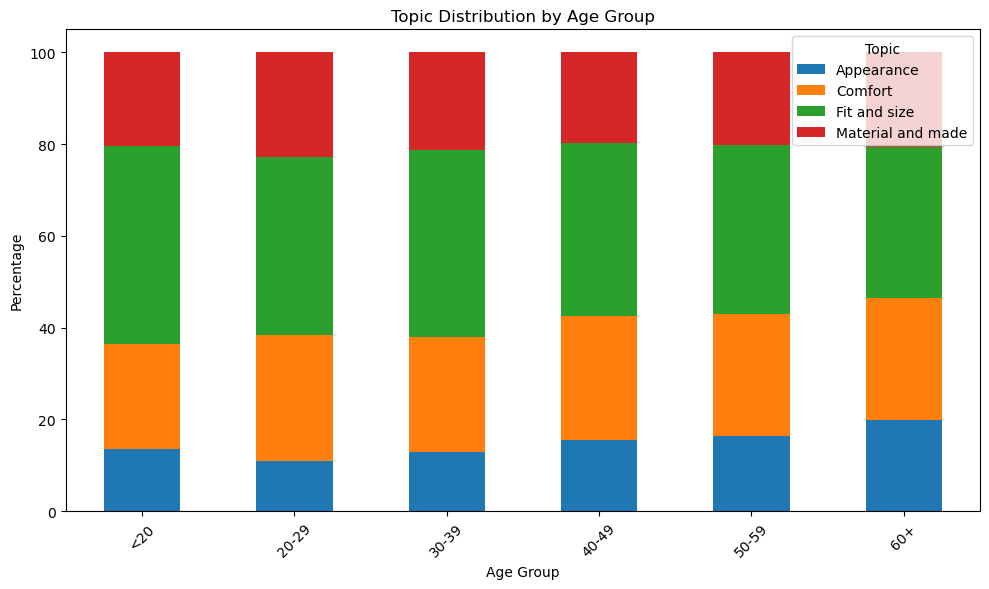

In [95]:
topic_distribution_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Topic Distribution by Age Group')
plt.ylabel('Percentage')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

In [96]:
# Analyze topic distribution by Recommended IND
topic_distribution_by_recommend = df.groupby('Recommended IND')['topic_name'].value_counts(normalize=True).unstack(fill_value=0) * 100


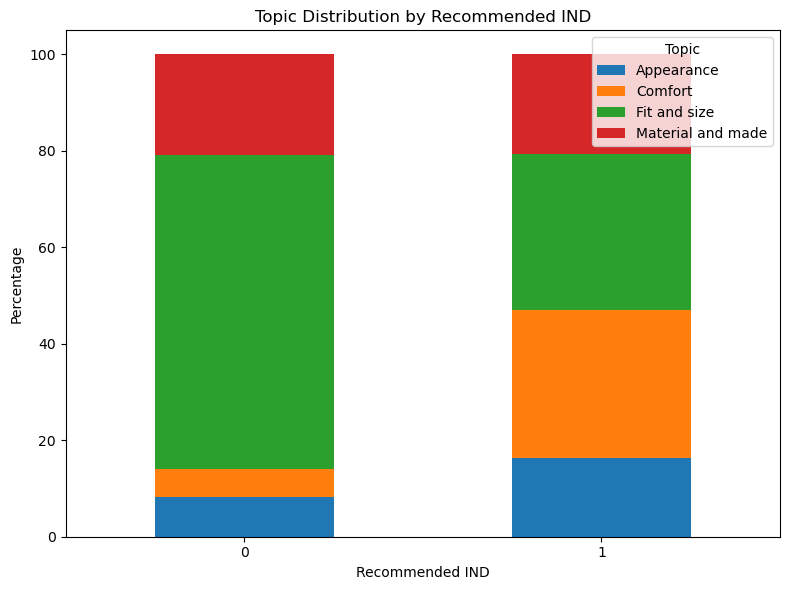

In [97]:
topic_distribution_by_recommend.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Topic Distribution by Recommended IND')
plt.ylabel('Percentage')
plt.xlabel('Recommended IND')
plt.xticks(rotation=0) #Keep x-axis labels horizontal
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

In [98]:
# Analyze topic distribution by Rating
topic_distribution_by_rating = df.groupby('Rating')['topic_name'].value_counts(normalize=True).unstack(fill_value=0) * 100


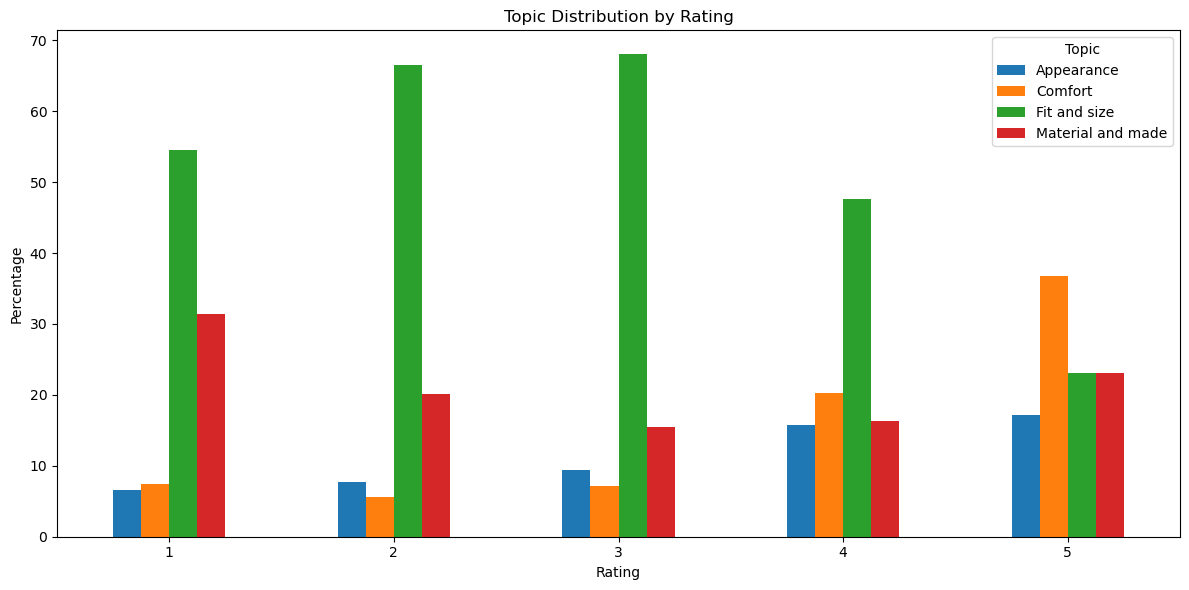

In [99]:
topic_distribution_by_rating.plot(kind='bar', figsize=(12, 6))
plt.title('Topic Distribution by Rating')
plt.ylabel('Percentage')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.legend(title='Topic')
plt.tight_layout()
plt.show()